# Experiments on real-world data

Code to obtain the results in Section 4 of NeurIPS 2021 Paper6977 submission,
for the proposed Conformal RNN model.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pickle
import torch

from matplotlib import pyplot as plt
%matplotlib inline

from utils.train_medical import run_medical_experiments

To obtain the results as presented in the paper, run the following three sections.

## MIMIC-III dataset

Training procedure for 5 different seeds:

```python
all_mimic_results = []
for seed in range(5):
    mimic_results = run_medical_experiments(retrain=True, dataset='mimic', seed=seed)
    all_mimic_results.append(mimic_results)
    
with open('saved_results/all_mimic_results.pkl', 'wb') as f:
    pickle.dump(all_mimic_results, f, protocol=pickle.HIGHEST_PROTOCOL)
```

Loading results:

In [5]:
with open('saved_results/all_mimic_results.pkl', 'rb') as f:
    all_mimic_results = pickle.load(f)

In [10]:
coverages = []
for mimic_results in all_mimic_results:
    cc = []
    for baseline in ['DPRNN', 'QRNN', 'CPRNN']:
        cc.append(mimic_results[baseline]['Mean joint coverage'])
    coverages.append(cc)

coverages = np.array(coverages)

for i, j in zip(coverages.mean(axis=0) * 100, coverages.std(axis=0) * 100):
    print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(i, j))

39.0 \(\pm\) 5.4\%
87.6 \(\pm\) 2.7\%
94.0 \(\pm\) 1.2\%


## EEG dataset

Training same as above, except:
```python
eeg_results = run_medical_experiments(retrain=True, dataset='eeg', seed=seed)
```

In [ ]:
with open('saved_results/all_eeg_results.pkl', 'rb') as f:
    all_eeg_results = pickle.load(f)

## COVID-19 dataset

Training same as above, except:
```python
covid_results = run_medical_experiments(retrain=True, dataset='covid', seed=seed)
```

In [ ]:
with open('saved_results/all_covid_results.pkl', 'rb') as f:
    all_covid_results = pickle.load(f)

## Example results analysis

This is for one seed and COVID-19 dataset; analysis of other datasets is analogous.

In [30]:
# This will load cached results for each baseline for the MIMIC-III dataset
covid_results = run_medical_experiments(dataset='covid')

Note that in this code CPRNN is equivalent to CoRNN.

In [31]:
covid_results['CPRNN'].keys()

dict_keys(['Point predictions', 'Errors', 'Independent coverage indicators', 'Joint coverage indicators', 'Upper limit', 'Lower limit', 'Mean independent coverage', 'Mean joint coverage', 'Confidence interval widths', 'Mean confidence interval widths'])

**Joint coverage**

In [ ]:
for baseline in ['DPRNN', 'QRNN', 'CPRNN']:
    print(covid_results[baseline]['Mean joint coverage'])

**Independent coverage**

In [ ]:
for baseline in ['DPRNN', 'QRNN', 'CPRNN']:
    independent_coverages = covid_results[baseline]['Mean independent coverage']
    print(independent_coverages)
    print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))
    print()

**Mean absolute error**

In [ ]:
for baseline in ['DPRNN', 'QRNN', 'CPRNN']:
    errors = covid_results[baseline]['Errors']
    print(errors.mean(axis=0)) 
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(errors.mean(), errors.std()))
    print()

**Interval widths**

In [ ]:
for baseline in ['DPRNN', 'QRNN', 'CPRNN']:
    print(covid_results[baseline]['Mean confidence interval widths'])
    print(covid_results[baseline]['Mean confidence interval widths'].mean(), covid_results[baseline]['Mean confidence interval widths'].std())
    print()

## Ablation: Uncorrected calibration scores

The results have been obtained by running:

```python
uncorrected_mimic_results = run_medical_experiments(retrain=True, dataset='mimic', baselines=['CPRNN'], correct_conformal=False)
uncorrected_eeg_results = run_medical_experiments(retrain=True, dataset='eeg', baselines=['CPRNN'], correct_conformal=False)
uncorrected_covid_results = run_medical_experiments(retrain=True, dataset='covid', baselines=['CPRNN'], correct_conformal=False)
```

The following will load the saved results.

#### MIMIC-III

In [6]:
uncorrected_mimic_results = run_medical_experiments(retrain=False, dataset='mimic', baselines=['CPRNN'], correct_conformal=False)

In [7]:
uncorrected_mimic_results['CPRNN']['Mean joint coverage']

0.878000020980835

In [8]:
independent_coverages = uncorrected_mimic_results['CPRNN']['Mean independent coverage']
print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))

[89.0\%, 89.8\%]


#### EEG

In [9]:
uncorrected_eeg_results = run_medical_experiments(retrain=False, dataset='eeg', baselines=['CPRNN'], correct_conformal=False)

In [10]:
uncorrected_eeg_results['CPRNN']['Mean joint coverage']

0.5795312523841858

In [11]:
independent_coverages = uncorrected_eeg_results['CPRNN']['Mean independent coverage']
print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))

[85.8\%, 90.6\%]


#### COVID-19

In [12]:
uncorrected_covid_results = run_medical_experiments(retrain=False, dataset='covid', baselines=['CPRNN'], correct_conformal=False)

In [13]:
uncorrected_covid_results['CPRNN']['Mean joint coverage']

0.574999988079071

In [14]:
independent_coverages = uncorrected_covid_results['CPRNN']['Mean independent coverage']
print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))

[77.5\%, 98.8\%]


## Long horizon analysis

### EEG

In [14]:
import torch
import numpy as np

import matplotlib.pyplot as plt

In [45]:
widths = {}
for rnn_model in ['LSTM', 'RNN', 'GRU']:
    model = torch.load('saved_models/eeg_CPRNN_{}.pt'.format(rnn_model))
    n_train = 15360
    
    ws = []
    alphas = np.arange(100) * 0.01
    for alpha in alphas:
        corrected_alpha = alpha / model.horizon
        corrected_critical_calibration_scores = torch.tensor([[
                torch.quantile(
                    position_calibration_scores,
                    q=1 - corrected_alpha * n_train / (n_train + 1))
                for position_calibration_scores in feature_calibration_scores]
                for feature_calibration_scores in model.calibration_scores]).T
        ws.append(corrected_critical_calibration_scores.flatten().tolist())
    ws = np.array(ws)
    ws = ws * 2
    widths[rnn_model] = ws

In [46]:
def compute_valid_horizons(threshold_width=15):
    valid_horizons = {}
    for rnn_model in ['LSTM', 'RNN', 'GRU']:    
        T = []
        ws = widths[rnn_model]
        for i, _ in enumerate(alphas):
            t = 0
            while t < ws.shape[1] and ws[i, t] < threshold_width:
                t += 1
            T.append(t)
        valid_horizons[rnn_model] = np.array(T)
    return valid_horizons

In [15]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({'axes.labelsize': 12})

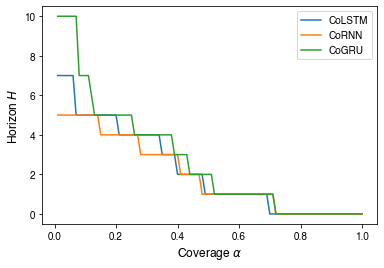

In [49]:
threshold_width = 25
valid_horizons = compute_valid_horizons(threshold_width)
for rnn_model in valid_horizons.keys():
    plt.plot(1-alphas, valid_horizons[rnn_model], label='Co{}'.format(rnn_model))
plt.xlabel('Coverage $\\alpha$')
plt.ylabel('Horizon $H$')
plt.legend()
plt.show()

In [30]:
widths = {}
for rnn_model in ['LSTM', 'RNN', 'GRU']:
    model = torch.load('saved_models/covid_CPRNN_{}.pt'.format(rnn_model))
    n_train = 15360
    
    ws = []
    alphas = np.arange(100) * 0.01
    for alpha in alphas:
        corrected_alpha = alpha / model.horizon
        corrected_critical_calibration_scores = torch.tensor([[
                torch.quantile(
                    position_calibration_scores,
                    q=1 - corrected_alpha * n_train / (n_train + 1))
                for position_calibration_scores in feature_calibration_scores]
                for feature_calibration_scores in model.calibration_scores]).T
        ws.append(corrected_critical_calibration_scores.flatten().tolist())
    ws = np.array(ws)
    ws = ws * 2
    widths[rnn_model] = ws